## Time Series - Births Data for England and Wales

In this Notebook I will analyse aspects of data on live births and fertility rates over time. Using data from the ONS on the number of live births per month  and the general fertility rate (number of live births per 1,000 women aged 15-44) in England and Wales (1938-2022) to create time series. I then go on to try and fit various models to the time series before thinking about how big an impact the legalisation of abortion had on declining general fertility rates.

The source of the data is:https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/bulletins/birthsummarytablesenglandandwales/2022refreshedpopulations

## IMPORTING AND CLEANING DATA

In [1]:
import pandas as pd
import numpy as np 
import datetime as dt
import re
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

#Read data in df
births_by_month_df=pd.read_excel('Data/birthssummary2022refreshedpopulations.xlsx', sheet_name='Table_4', skiprows=lambda x: x in [0,1,2,3,4,5]) 
births_by_month_df.head()

,Year,England and Wales\nTotal,England and Wales\nJanuary,England and Wales\nFebruary,England and Wales\nMarch,England and Wales\nApril,England and Wales\nMay,England and Wales\nJune,England and Wales\nJuly,England and Wales\nAugust,England and Wales\nSeptember,England and Wales\nOctober,England and Wales\nNovember,England and Wales\nDecember
0,2022,605479,49711,46349,51230,48376,51245,49833,52042,52123,52180,52845,50356,49189
1,2021,624828,47742,46258,52481,50278,51329,52204,55385,54287,55296,55705,52498,51365
2,2020,613936,52804,48317,51080,49337,52094,51495,53515,51662,53079,53624,49638,47291
3,2019,640370,53677,48203,52880,51148,55108,53539,56440,55359,55164,55281,51922,51649
4,2018,657076,56173,48792,53875,52639,56599,54968,56824,56719,56145,56663,54037,53642


In [2]:
#Use regexes to clean column names
pattern = 'England and Wales\n'
births_by_month_df = births_by_month_df.rename(columns=(lambda x : re.sub(pattern, '', x)))


#Drop 'Total' column 
births_by_month_df = births_by_month_df.drop ('Total', axis=1)
births_by_month_df.head()


#Set year as index
births_by_month_df = births_by_month_df.set_index('Year')


births_by_month_df.head()


,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2022,49711,46349,51230,48376,51245,49833,52042,52123,52180,52845,50356,49189
2021,47742,46258,52481,50278,51329,52204,55385,54287,55296,55705,52498,51365
2020,52804,48317,51080,49337,52094,51495,53515,51662,53079,53624,49638,47291
2019,53677,48203,52880,51148,55108,53539,56440,55359,55164,55281,51922,51649
2018,56173,48792,53875,52639,56599,54968,56824,56719,56145,56663,54037,53642


In [3]:
#Rename columns as integers corresponding to months
numbers = list(range(1,13))
births_by_month_df.columns = numbers
births_by_month_df = births_by_month_df.reset_index()
births_by_month_df.head()

,Year,1,2,3,4,5,6,7,8,9,10,11,12
0,2022,49711,46349,51230,48376,51245,49833,52042,52123,52180,52845,50356,49189
1,2021,47742,46258,52481,50278,51329,52204,55385,54287,55296,55705,52498,51365
2,2020,52804,48317,51080,49337,52094,51495,53515,51662,53079,53624,49638,47291
3,2019,53677,48203,52880,51148,55108,53539,56440,55359,55164,55281,51922,51649
4,2018,56173,48792,53875,52639,56599,54968,56824,56719,56145,56663,54037,53642


In [4]:
#Melt dataframe to produce timeseries
births_by_month_df = pd.melt(births_by_month_df, id_vars=['Year'], var_name="Month", value_name = "Live Births")
births_by_month_df

,Year,Month,Live Births
0,2022,1,49711
1,2021,1,47742
2,2020,1,52804
3,2019,1,53677
4,2018,1,56173
...,...,...,...
1015,1942,12,54404
1016,1941,12,49373
1017,1940,12,46336
1018,1939,12,48309


In [5]:
#Create date column turning Year and Month to datetime
births_by_month_df['Date'] = pd.to_datetime(births_by_month_df[['Year', 'Month']].assign(DAY=1))
births_by_month_df['Month'] = births_by_month_df['Month'].astype(float)
births_by_month_df=births_by_month_df.sort_values('Date')
births_by_month_df = births_by_month_df.set_index('Date')
births_by_month_df.head()

,Year,Month,Live Births
Date,,,
1938-01-01,1938,1.0,51820
1938-02-01,1938,2.0,47421
1938-03-01,1938,3.0,54887
1938-04-01,1938,4.0,54623
1938-05-01,1938,5.0,56853


## PRODUCING TIME SERIES AND ASSESSING SEASONALITY

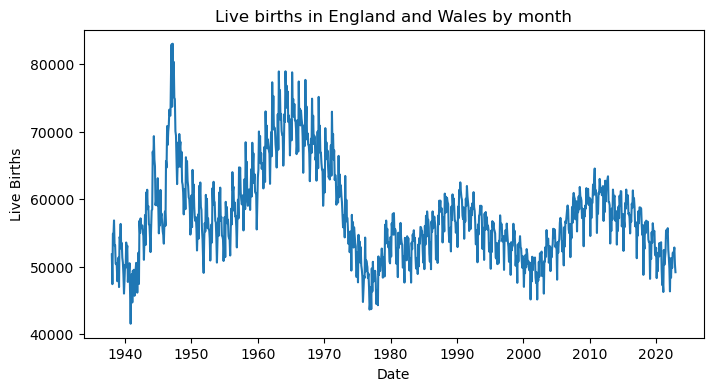

In [6]:
#Draw time series
ax = sns.lineplot(data=births_by_month_df, x=births_by_month_df.index, y='Live Births')
ax.figure.set_size_inches(8, 4)
ax.set_title('Live births in England and Wales by month')
plt.show()

Looking at the time series it obviously has a trend componenent with the number of births increasing and decreasing over time. The number of live births per month peaked in c.1947 and c.1964 and since then has oscillated between about 43,000 and 61,000. 

There does seem to be a seasonal component to the time series which is likely an annual one. I shall look at this further using a seasonal plot. 

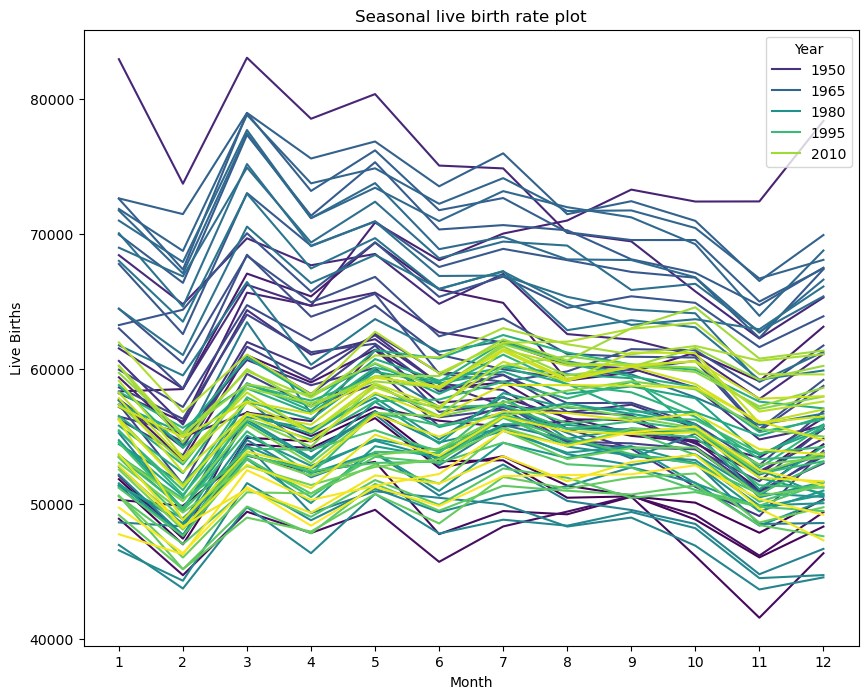

In [7]:
#Draw seasonal plot
ax = sns.lineplot(data=births_by_month_df, x='Month', y='Live Births',
                  hue='Year', palette='viridis')
ax.figure.set_size_inches(10, 8)
ax.set_xticks(births_by_month_df['Month'].unique())
ax.set_title('Seasonal live birth rate plot')
plt.show()

From the seasonal plot above it is clear there is a seasonal component to the time series as for the majority of years the plots follow a similar pattern.

The data seems to show peaks with troughs immediately coming after so it seems the number of days in the month is having an effect, for example the lowest number of births often comes in February which might be expected as it is the shortest month. However, there does also seem to be a broader seasonal trend not dependent on number of days in a month with peaks in March and May. 

Looking closely at the plot there does seem to be a change in the seasonal variation as time goes on. The later plots show a decrease in variation over the months which might be expected given the lower numbers of live births but there also appears to be some difference in the overall seasonal pattern compared with earlier years in the time series.

It appears that the seasonal component is not independent of the trend component and therefore a multiplicative decomposition model  of $X_t = m_t \times s_t \times W_t$ where $m_t$ is the trend component, $s_t$ is the seasonal component and $W_t$ is the irregular component is more appropriate than an additive one for this time series. 

In order to make modelling simpler I would like to transform the time series for which an additive model is appropriate so in order to do this I will use the model $Y_t = log(X_t)$ by taking the natural log of live births per months. 

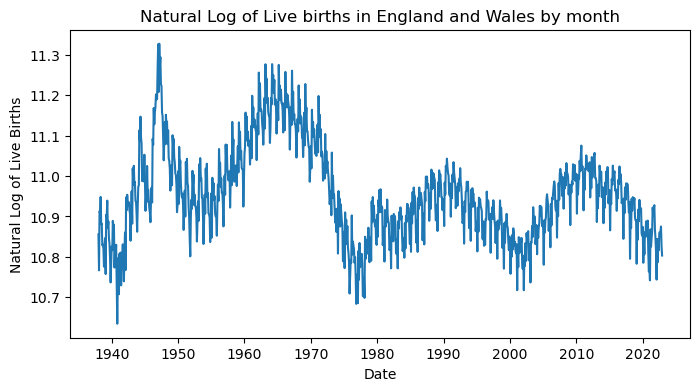

In [8]:
#Produce column with natural log of live births
births_by_month_df['Natural Log of Live Births'] = np.log(births_by_month_df['Live Births'])

#Draw time series
ax = sns.lineplot(data=births_by_month_df, x=births_by_month_df.index, y='Natural Log of Live Births')
ax.figure.set_size_inches(8, 4)
ax.set_title('Natural Log of Live births in England and Wales by month')
plt.show()

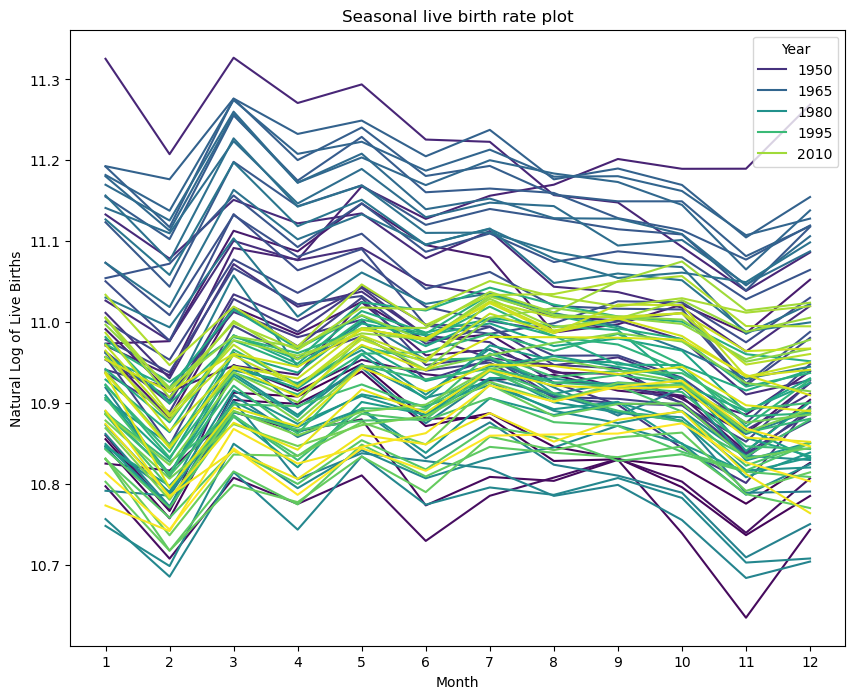

In [9]:
#Draw seasonal plot
ax = sns.lineplot(data=births_by_month_df, x='Month', y='Natural Log of Live Births',
                  hue='Year', palette='viridis')
ax.figure.set_size_inches(10, 8)
ax.set_xticks(births_by_month_df['Month'].unique())
ax.set_title('Seasonal live birth rate plot')
plt.show()

Looking at the plots taking the natural log means the time series displays the same period of seasonality as the original but the fluctuations appear to be of roughly the same size wherever they appear in the series which suggests that an additive model is appropriate for the log transformed series.  

Now I will decompose the log transformed series into its constituent parts. 

## DECOMPOSING TIME SERIES

In [10]:
#Calculate trend component
births_by_month_df['Trend'] = births_by_month_df['Natural Log of Live Births']. rolling(window = 13, center=True).mean()

#Detrend the series
births_by_month_df['Detrended'] = births_by_month_df['Natural Log of Live Births'] - births_by_month_df['Trend']

# calculate the seasonal component
#seasonal_df.index = pd.to_datetime(seasonal_df.index)
births_by_month_df["Month"] = births_by_month_df.index.month
births_by_month_df["Seasonality"] = births_by_month_df.groupby("Month")["Detrended"].transform("mean")

# get the residuals
births_by_month_df["Residuals"] = births_by_month_df["Detrended"] - births_by_month_df["Seasonality"]

births_by_month_df.head(12)


,Year,Month,Live Births,Natural Log of Live Births,Trend,Detrended,Seasonality,Residuals
Date,,,,,,,,
1938-01-01,1938,1,51820,10.855531,NaN,NaN,-0.002642,NaN
1938-02-01,1938,2,47421,10.766820,NaN,NaN,-0.069679,NaN
1938-03-01,1938,3,54887,10.913032,NaN,NaN,0.042084,NaN
1938-04-01,1938,4,54623,10.908210,NaN,NaN,-0.000684,NaN
1938-05-01,1938,5,56853,10.948224,NaN,NaN,0.049810,NaN
1938-06-01,1938,6,53145,10.880779,NaN,NaN,0.009611,NaN
1938-07-01,1938,7,53214,10.882077,10.852595,0.029482,0.036323,-0.006841
1938-08-01,1938,8,50444,10.828619,10.845069,-0.016450,0.016840,-0.033289
1938-09-01,1938,9,50545,10.830619,10.855615,-0.024995,0.008026,-0.033021


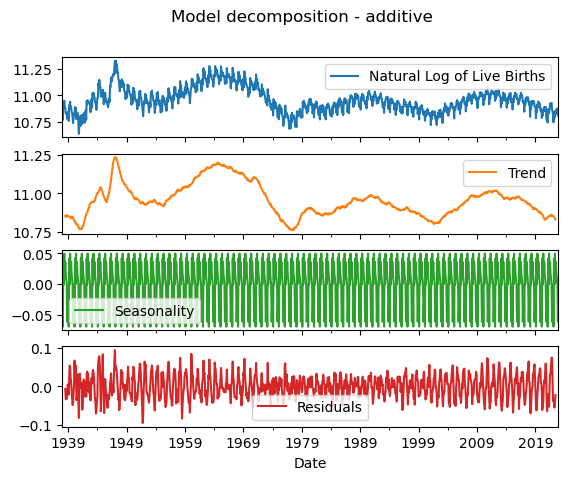

In [11]:
#Plot different components of transformed additive model 
(births_by_month_df.loc[:, ["Natural Log of Live Births", "Trend", "Seasonality", "Residuals"]].plot(subplots=True, title="Model decomposition - additive")
);

Now I will use the seasonal_decompose method from the statsmodel library to see if it obtains similar results to my decomposing manually.

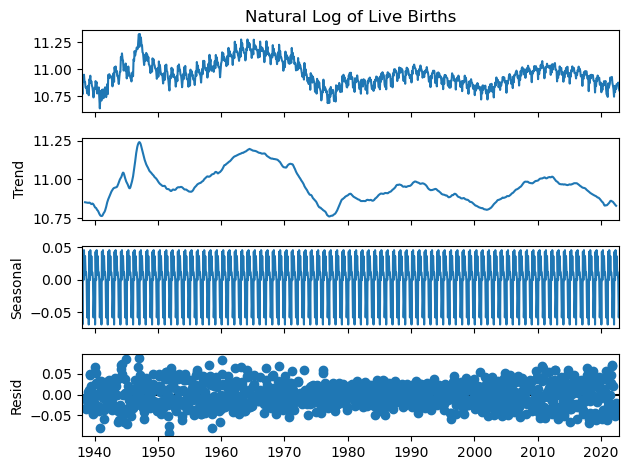

In [12]:
#Create time series
birth_series = pd.Series(births_by_month_df['Natural Log of Live Births'])

#Call seasonal_decompose
decompose_result = seasonal_decompose(birth_series, model="additive")
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

#Plot decomposition
decompose_result.plot();

The results of my manual decomposition and that performed by statsmodel look to be very similar so that is good. On both analyses there does seem to be a pattern in the residuals. While it has a mean of approximately zero the variance is not constant, it tends to be smaller in the middle section of the plot from about 1970-1998. I will keep this in mind.

Given I spotted some variation in the seasonal plots over the course of the time series I would also like to examine the decomposition using a STL or 'Seasonal and Trend decomposition using Loess' decomposition as this methods allows for a seasonal rate which varies over time. 

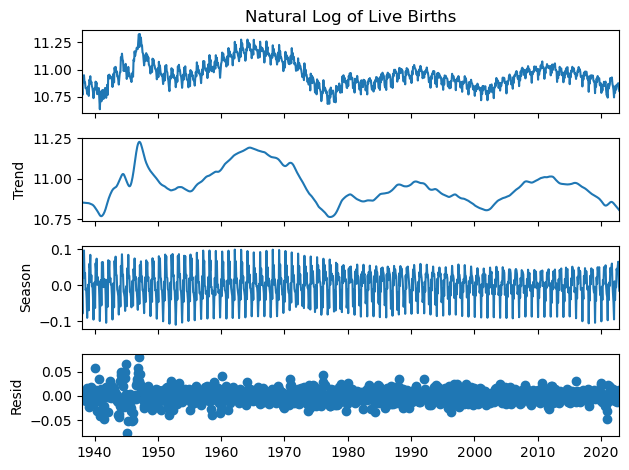

In [13]:
from statsmodels.tsa.seasonal import STL
results = STL(birth_series).fit()
results.plot()
plt.show()


From the STL decomposition it does seem that the seasonal component varies over time with less variance from about 1985-2013. 

## HOLT-WINTERS EXPONENTIAL SMOOTHING

Now I shall look at using Holt-Winters exponential smoothing to model the transformed time series as it has both a trend component and a seasonal component. However, given Holt-Winters is designed to work on time series with a linear trend I am not expecting great results from the model. 

In [14]:
births_by_month_df.index.freq = 'MS'

# Construct the exponential smoothing model
births_by_month_df['ETSModel'] = ETSModel(
    endog=births_by_month_df['Natural Log of Live Births'],
    trend='add',
    damped_trend=0,
    seasonal='add',
    seasonal_periods=12).fit().fittedvalues


births_by_month_df.head()

,Year,Month,Live Births,Natural Log of Live Births,Trend,Detrended,Seasonality,Residuals,ETSModel
Date,,,,,,,,,
1938-01-01,1938,1,51820,10.855531,NaN,NaN,-0.002642,NaN,10.855107
1938-02-01,1938,2,47421,10.766820,NaN,NaN,-0.069679,NaN,10.773816
1938-03-01,1938,3,54887,10.913032,NaN,NaN,0.042084,NaN,10.888031
1938-04-01,1938,4,54623,10.908210,NaN,NaN,-0.000684,NaN,10.886923
1938-05-01,1938,5,56853,10.948224,NaN,NaN,0.049810,NaN,10.939041


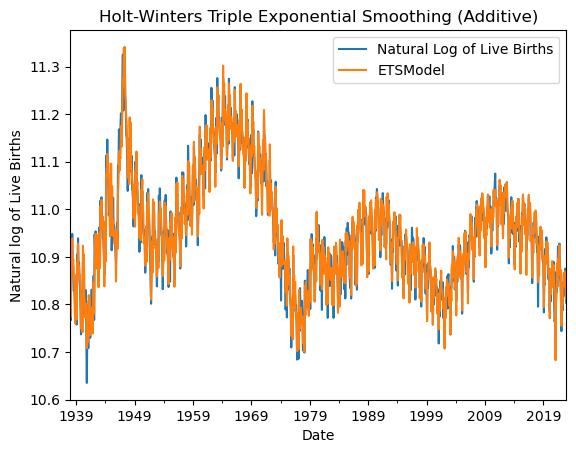

In [15]:
#Plot data and Holt-Winters exponential smoothing
births_by_month_df[['Natural Log of Live Births','ETSModel']].plot(title='Holt-Winters Triple Exponential Smoothing (Additive)', ylabel = 'Natural log of Live Births').autoscale(axis='x',tight=True);

The Holt_Winters method has mapped closely to the transformed data but the proof of the pudding will be in its ability to forecast. 

In [16]:
#Length of data
len(births_by_month_df)

1020

In [17]:
# Split into train and test set
train_births = births_by_month_df[:950] 
test_births = births_by_month_df[950:]

len(test_births)

70

In [18]:
#Fit exponential smoothing model 
fitted_model = ETSModel(
    endog=train_births['Natural Log of Live Births'],
    trend='add',
    damped_trend=0,
    seasonal='add',
    seasonal_periods=12).fit()

In [19]:
#Generate forecasts
test_predictions = fitted_model.forecast(70).rename('HW Test Forecast')

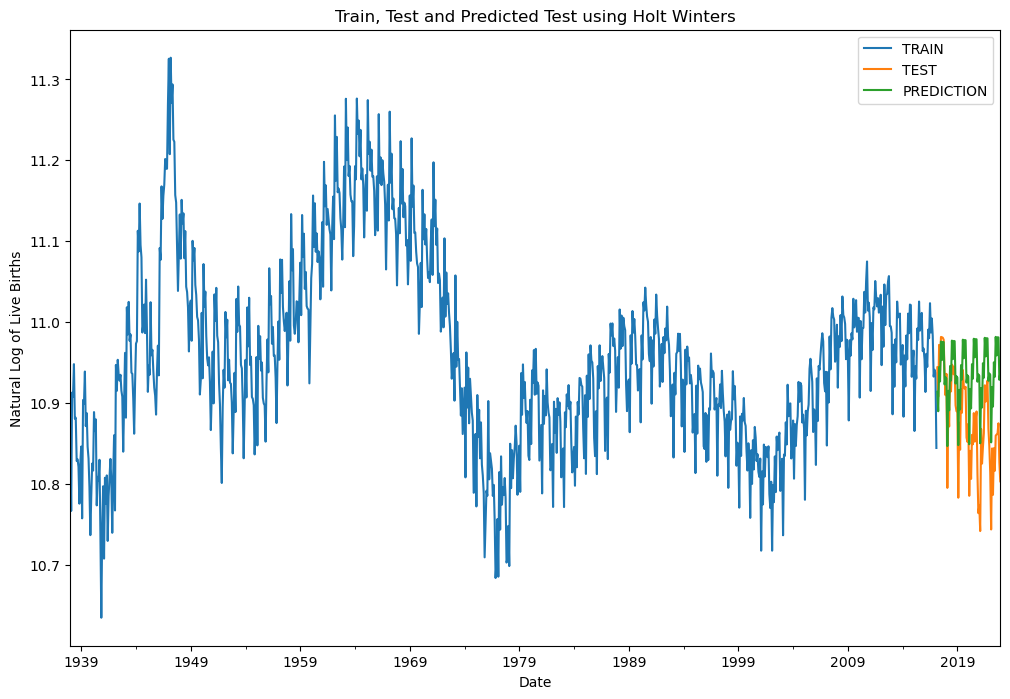

In [20]:
#Plot training, testing and predicted data 
train_births['Natural Log of Live Births'].plot(legend=True,label='TRAIN')
test_births['Natural Log of Live Births'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.ylabel('Natural Log of Live Births');

As predicted the Holt-Winters model has not performed well on predictions as it has predicted a general linear trend so depending on where the divide between the test and train data is depends on whether its predictions even head in the correct direction. 

## FITTING AND TESTING AN ARIMA MODEL

I would like to go on to test ARIMA models on the time series. However, these work best on non-seasonal data. So while I could use the trend plus the residuals of the adjusted series to produce a seasonally adjusted series, I am instead going to move to using the general fertility rate. This is the number of live births per 1,000 women aged 15-44. It is an annual calculation so doesn't involve any seasonality but  unlike the live births data it also takes into account changes in the underlying population numbers. 

In [21]:
#Read in general fertility data and set up dataframe 
gfr_df=pd.read_excel('Data/birthssummary2022refreshedpopulations.xlsx', sheet_name='Table_1', skiprows=lambda x: x in [0,1,2,3,4,5,6,7]) 
gfr_df = gfr_df[['Year', 'General Fertility Rate (GFR): all live births per 1,000 women aged 15 to 44']]
gfr_df = gfr_df.rename(columns={'General Fertility Rate (GFR): all live births per 1,000 women aged 15 to 44': 'General Fertility Rate'})
gfr_df = gfr_df.dropna()
#print(len(gfr_df))
#print(gfr_df.dtypes)

#Drop rows with no data 
n = 100
gfr_df = gfr_df.drop(gfr_df.tail(n).index)

#Sort values
gfr_df=gfr_df.sort_values('Year')

#Drop 2022 data which I will use to check the forecast. 
n = 1
gfr_df = gfr_df.drop(gfr_df.tail(n).index)

#Set 'year' to datetime and index
gfr_df['Year'] = pd.to_datetime(gfr_df[['Year']].assign(MONTH = 1, DAY=1))
gfr_df= gfr_df.set_index('Year').asfreq('YS')

gfr_df = gfr_df.astype(float)

gfr_df.tail()

,General Fertility Rate
Year,
2017-01-01,59.7
2018-01-01,57.6
2019-01-01,55.8
2020-01-01,53.4
2021-01-01,54.1


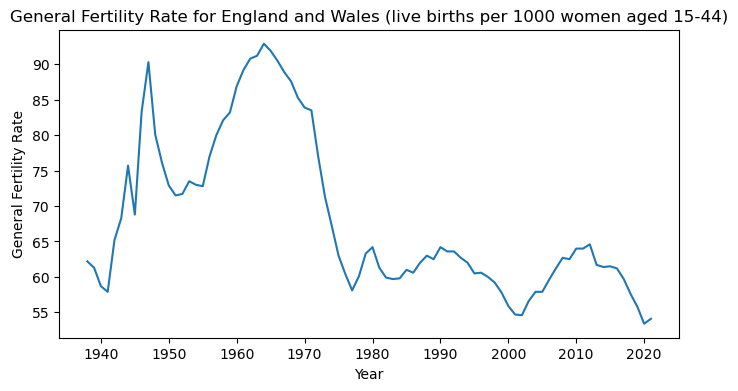

In [22]:
#Draw time series of general fertility rate
ax = sns.lineplot(data=gfr_df, x=gfr_df.index, y='General Fertility Rate')
ax.figure.set_size_inches(8, 4)
ax.set_title('General Fertility Rate for England and Wales (live births per 1000 women aged 15-44)')
plt.show()

The general fertility rate time series is a similar shape to the live births data so it reflects the same trend and cycles of changing birth rates. However, because it takes population growth into account it shows the overall decline in birth rate  since the early 1960s more precisely. 

In order to use ARIMA models the time series has to be stationary. I shall use the weak definition of stationary which requires a time series $X_t$ to be stationary if it satisfies the conditions: 

$E_(X_t) = \mu$ - a constant mean

$V(X_t) = \sigma$ - a constant variance

For all $k, p_k$, the autocorrelation between $X_t$ and $X_{t-k}$, does not vary with t but depends only on the lag $k$. 

In the case of the general fertility rate time series the mean is not constant and neither is the variance because as the fertility rate declines the height of the peaks and troughs decreases. The third condition of stationary in correlation cannot be determined by inspecting a time plot therefore I shall assume this time series is stationary in correlation.

As the time series is not stationary to fit an ARIMA model I shall have to find an appropriate degree of differencing.

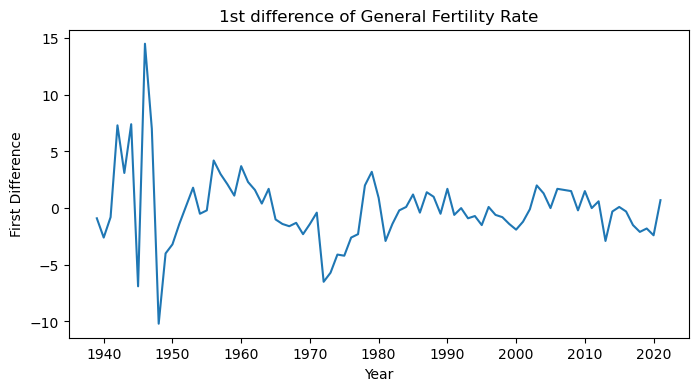

In [23]:
#Calculate first difference
gfr_df['First Difference'] = gfr_df['General Fertility Rate'].diff()


ax = sns.lineplot(data=gfr_df, x=gfr_df.index, y='First Difference')
ax.figure.set_size_inches(8, 4)
ax.set_title('1st difference of General Fertility Rate')
plt.show()

Neither the mean nor the variance appear to be constant so the first difference is not stationary so I shall try the second difference.

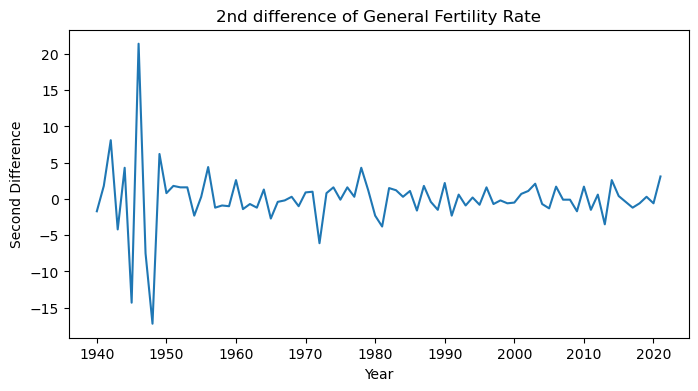

In [24]:
#Calculate second difference
gfr_df['Second Difference'] = gfr_df['First Difference'].diff()

#Plot second difference
ax = sns.lineplot(data=gfr_df, x=gfr_df.index, y='Second Difference')
ax.figure.set_size_inches(8, 4)
ax.set_title('2nd difference of General Fertility Rate')
plt.show()

For the second difference the mean appears to now be constant and averaging around zero so the time series is stationary in mean. The variance is still showing some pattern with the period of c. 1940-50 showing a higher variance than the later years in the series. However, I do not want to over-difference the series so I shall stick with the second differencing. 

There may be an argument for only using post-1950 data as it is likely that the Second World War had a massive and unrepeated impact on the data as the years from 1940 to 1950 show sharp peaks and troughs in the general fertility rate quite unlike the rest of the data. But in this case I shall continue to use the full dataset. 

Now I shall look at the ACF and PACF to determine the p and q factors in the ARIMA model. 

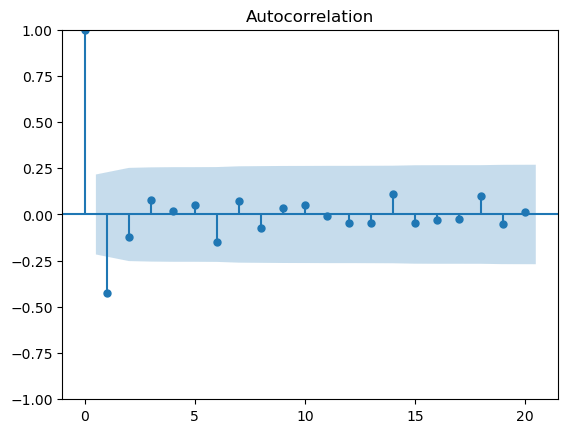

In [25]:
#Create time series
gfr_series = pd.Series(gfr_df.iloc[2:,2])

#Generate and plot autocorrelation 
plot_acf(gfr_series, lags=20);


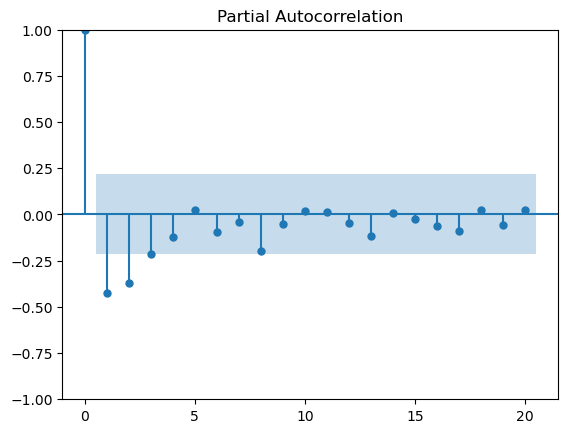

In [26]:
#Generate and plot  partial autocorrelation
plot_pacf(gfr_series, lags = 20, method = "ols");

Looking at the plots:

- The autocorrelations are close to zero after lag 1.
- The partial autocorrelations tail off with increasing lag.  

This indicates that a moving average model of order 1 is a reasonable choice. 

So along with the differencing this would result in a model ARIMA(0,2,1). 


Now I shall use the statsmodel ARIMA method to fit the model I have identified to the data.  

In [27]:
model = ARIMA(gfr_df['General Fertility Rate'], order=(0, 2, 1))
result = model.fit()

Now to check the model. First I will produce a timeplot of the observed and the fitted values.

In [28]:
#Add forecast to df
gfr_df['Forecast'] = result.predict()

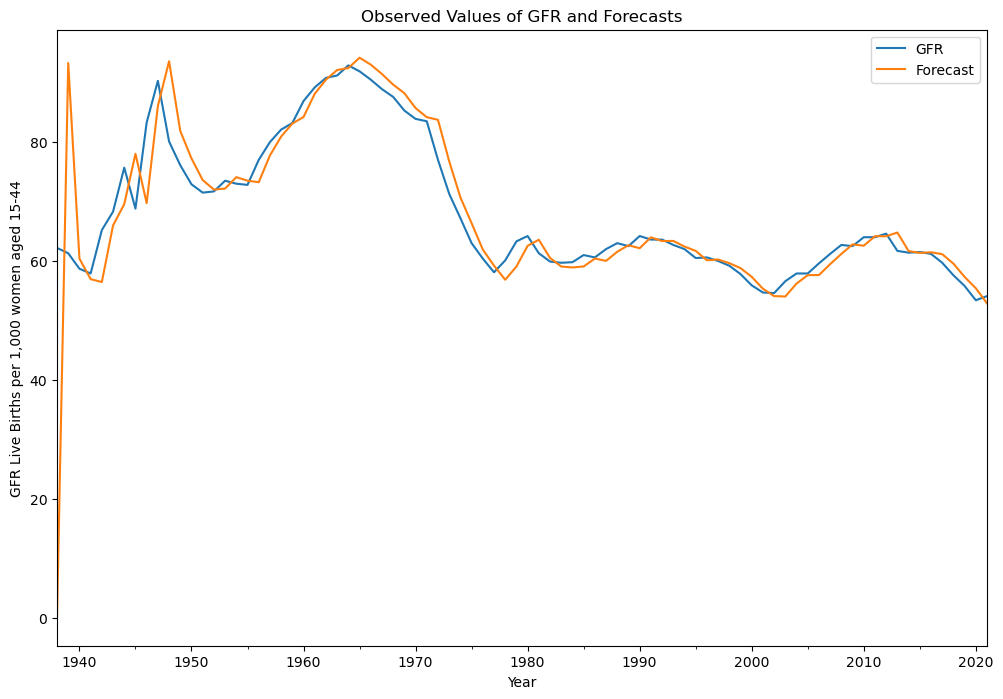

In [29]:
#Plot training, testing and predicted data 
gfr_df['General Fertility Rate'].plot(legend=True,label='GFR')
gfr_df['Forecast'].plot(legend=True,label='Forecast',figsize=(12,8))

plt.title('Observed Values of GFR and Forecasts')
plt.ylabel('GFR Live Births per 1,000 women aged 15-44');

Aside from the first two predictions (which were presumably affected by the two degrees of differencing) the ARIMA (0,2,1) model seems to fit pretty well against the observed data. I will now check the distribution of the forecast errors to see if they are approximately normal with mean zero and constant variance.    

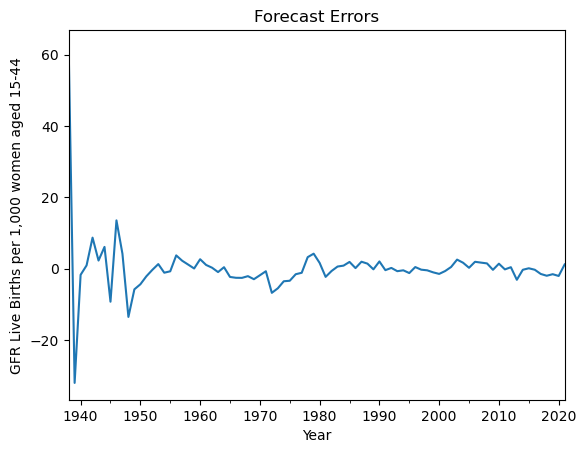

In [30]:
#Calculate forecast errors
gfr_df['Forecast Errors'] = gfr_df['General Fertility Rate'] - gfr_df['Forecast']

#Plot forecast errors
gfr_df['Forecast Errors'].plot()
plt.title('Forecast Errors')
plt.ylabel('GFR Live Births per 1,000 women aged 15-44');

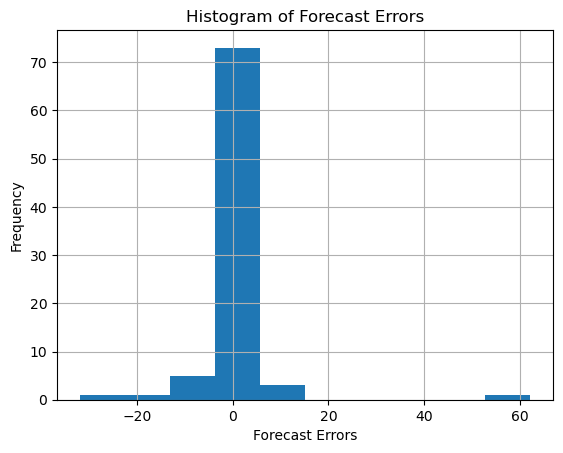

In [31]:
#Plot histogram of forecast errors
# Plot a histogram of a single column in the DataFrame
gfr_df.hist(column='Forecast Errors')

# Set the title and axis labels
plt.title('Histogram of Forecast Errors')
plt.xlabel('Forecast Errors')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

The plot and histogram show the forecast errors have a mean of zero. The variance is constant over the majority of the series and the distribution of the errors is approximately normal (the two large errors are presumably where the model predictions for the first two values are way off due perhaps to differencing). 

So far the model does seem to be a reasonable one but I want to test the forecast errors are uncorrelated using a correlogram and the Ljung-Box test.  

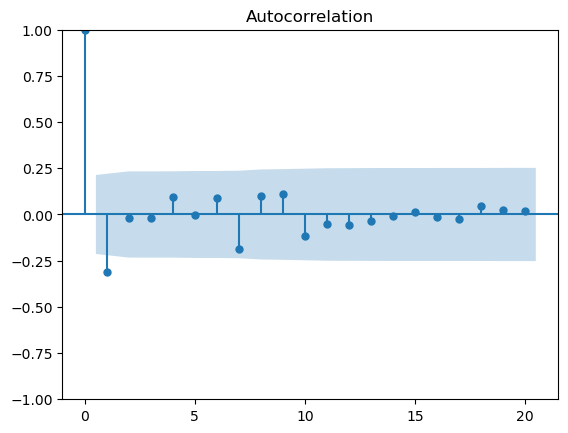

In [32]:
#Generate and plot autocorrelation of forecast errors
plot_acf(gfr_df['Forecast Errors'], lags=20);

In [33]:
print(result.summary())

                                 SARIMAX Results                                  
Dep. Variable:     General Fertility Rate   No. Observations:                   84
Model:                     ARIMA(0, 2, 1)   Log Likelihood                -214.056
Date:                    Fri, 15 Mar 2024   AIC                            432.112
Time:                            18:44:55   BIC                            436.926
Sample:                        01-01-1938   HQIC                           434.045
                             - 01-01-2021                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9319      0.053    -17.695      0.000      -1.035      -0.829
sigma2        10.5725      1.001     10.565      0.000       8.611      12.534
Ljung-Box (L1) (Q): 

The ACF shows the autocorrelations at lags 1-20 are for the most part very small and with one exception lie within the significance bounds. Due to the way significance bounds are calculated the probability of obtaining a value outside the bounds is 0.95 we might expect to see one value in twenty exceeding the bounds by chance if the underlying autocorrelations are zero. 

The Ljung-Box test has a statistic of 1.92 and a p value of 0.17. This p value provides little evidence against the null hypothesis that the autocorrelations at lags 1 to 20 are zero. 

Overall I conclude the ARIMA (0,2,1) is adequate for the data and I will see what the model forecasts for 2022. 

In [34]:
#forecast 2022 data, 2022 true value is 51.8
print(result.forecast(steps=1))



2022-01-01    53.661209
Freq: AS-JAN, dtype: float64


The ARIMA model forecasted a value of 53.66 for2022 whereas the actual general fertility rate was 51.8 so it is fairly close.   

## THINKING ABOUT FACTORS BEHIND CHANGING TREND 

In addition to the "spikiness" of the data from 1940-1950 another key feature of the time series of the General Fertility Rate is the relatively rapid decline in the fertility rate from around 1970. There are several factors which could help explain some of this decline. One is abortion which was legalised in the UK in 1968 (The Abortion Act 1967 came into force April 1968) which could account for the decline in general fertility rates which measures live births. The other factor is the wider availability and possible increase in uptake of methods of contraception including the pill which became more widely available after the NHS Family Planning Act of 1967. 

In order to assess the impact of abortion (which is easier to find figures on than historical use of contraceptives) I am going to look at figures from the ONS on the number of abortions. What would have been quite useful e would be the abortion rate per 1,000 women aged 15-44 as I could have measured this directly with the general fertility rate. However, I couldn't find this amongst the ONS available statistics so I am going to use their figures from 1968-2018 on the number of  abortions per year which can be found at
https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/conceptionandfertilityrates/bulletins/conceptionstatistics/2018.

And combine this with the number of live births per year which can be found at  https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/datasets/birthsummarytables/2022/birthssummary2022refreshedpopulations.xlsx.

Both these sources measure overall numbers rather than the general fertility rate which takes population changes into account.  

In [35]:
#Read data in df
annual_abortions_df=pd.read_excel('Data/abortions_data_ONS.xlsx', skiprows=lambda x: x in [0,1,2,3,4,5]) 
#print( list(annual_abortions_df.columns.values))
annual_abortions_df = annual_abortions_df.drop(['Number of conceptions ', 'Number of births'], axis=1)
annual_abortions_df['Number of abortions'] = annual_abortions_df['Number of abortions'].astype(float)
annual_abortions_df.head()

,Year,Number of abortions
0,1969,49.8
1,1970,76.0
2,1971,94.6
3,1972,108.6
4,1973,110.6


Looking at the ONS website all columns are measured in 1,000s. The number of conceptions is an estimation and I am not clear how this estimate is produced. So I am going to look at the number abortions from this source (in the period 1969 to 2018) and live births over the period (1938-2022) from the original spreadsheet I used to get an idea of how much of the decline in the number of births may be explained by the legalisation and availability of abortions.    

In [36]:
#Read in number of live births per year and set up dataframe
annual_births_df=pd.read_excel('Data/birthssummary2022refreshedpopulations.xlsx', sheet_name='Table_1',  skiprows=lambda x: x in [0,1,2,3,4,5,6,7])
annual_births_df = annual_births_df[['Year', 'Number of live births\nTotal']]
annual_births_df = annual_births_df.rename(columns={'Number of live births\nTotal': 'Number of live births'})
annual_births_df = annual_births_df.sort_values('Year')
annual_births_df.head()

,Year,Number of live births
184,1838,463787
183,1839,492574
182,1840,502303
181,1841,512158
180,1842,517739


In [37]:
#Combine number of abortions and number of live births into a single df
combined_df = pd.merge(annual_births_df, annual_abortions_df, how='outer', on='Year')
combined_df.head()

,Year,Number of live births,Number of abortions
0,1838,463787,NaN
1,1839,492574,NaN
2,1840,502303,NaN
3,1841,512158,NaN
4,1842,517739,NaN


In [38]:
#Only include data from 1938
combined_df = combined_df[(combined_df['Year'] >= 1938)]

#Set 'year' to datetime and index
combined_df['Year'] = pd.to_datetime(combined_df[['Year']].assign(MONTH = 1, DAY=1))
combined_df= combined_df.set_index('Year').asfreq('YS')

#Divide live births by 1000 to be roughly in line with abortions
combined_df['Number of live births'] = combined_df['Number of live births']/1000


In [39]:
combined_df['Number of births plus abortions'] = combined_df['Number of live births']+combined_df['Number of abortions']
combined_df.head()

,Number of live births,Number of abortions,Number of births plus abortions
Year,,,
1938-01-01,621.204,NaN,NaN
1939-01-01,614.479,NaN,NaN
1940-01-01,590.120,NaN,NaN
1941-01-01,579.091,NaN,NaN
1942-01-01,651.503,NaN,NaN


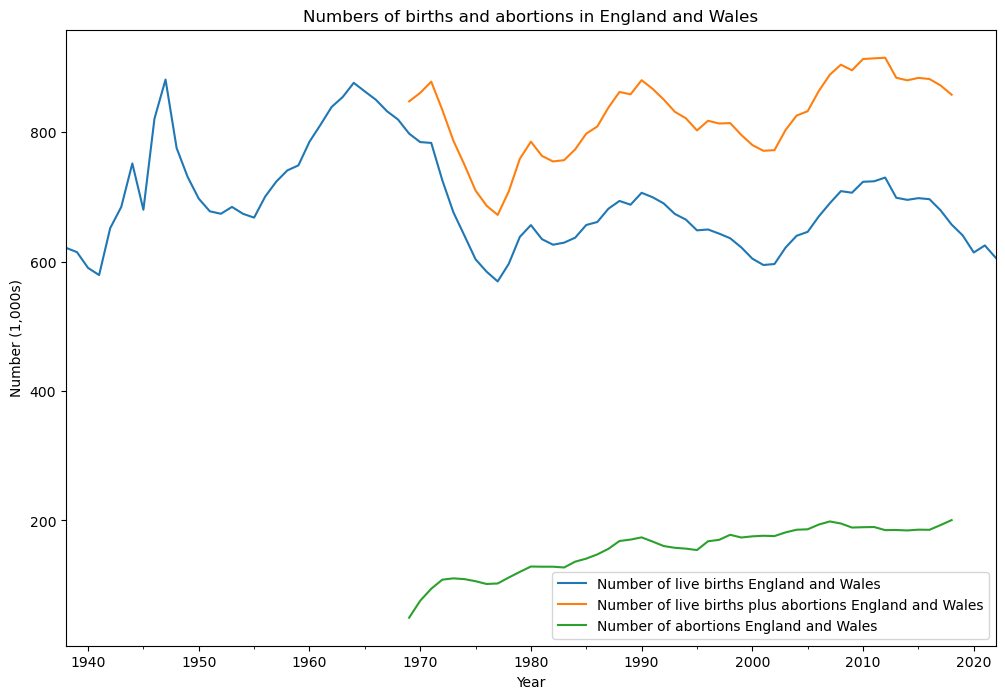

In [40]:
#Plot training, testing and predicted data 
combined_df['Number of live births'].plot(legend=True,label='Number of live births England and Wales')
combined_df['Number of births plus abortions'].plot(legend=True,label='Number of live births plus abortions England and Wales',figsize=(12,8))
combined_df['Number of abortions'].plot(legend=True,label='Number of abortions England and Wales',figsize=(12,8))

plt.title('Numbers of births and abortions in England and Wales')
plt.ylabel('Number (1,000s)');

On the plot above I graphed the number of live births plus abortions to get a broad sense of the impact of the legalisation of abortion on numbers of live births. This analysis is fairly crude as it relies on the assumptions that every abortion would have resulted in a live birth had abortion not been available legally which is not the case for a number of reasons, and that people's behaviour would have remained the same in the absence of legal abortion being available. However, it is clear from the data and numbers of abortions annually that the legalisation of abortion in 1968 is likely to be one of the factors that had an impact on the decline in the general fertility rate seen in the data from 1968 onwards. 

In [41]:
#To do:
#Try using a SARIMAX model on the natural log of live births
#per month data with seasonal factors included.

#Look at using pmdarima Auto ARIMA model to automate the calculations
#in creating an ARIMA model and see how the model compares with the 
#model ARIMA(0,2,1) where I determined the p,d and q parameters. 

#Read up on CARIMA models as described in article 'Projecting 
#age-specific fertility rates by using time-series methods' 
#https://pubmed.ncbi.nlm.nih.gov/12316169/